# Dataset Analysis and Visualization

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from collections import Counter
import json
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully")


Libraries imported successfully


In [16]:
# Load dataset configuration for local XML annotations
ANNOTATIONS_DIR = Path("rubbish")
CLASSES_TXT = Path("rubbish/classes.txt")  # Use the classes from rubbish dataset

# Load classes
with open(CLASSES_TXT, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print(f"Dataset contains {len(classes)} classes:")
for i, cls in enumerate(classes):
    print(f"  {i}: {cls}")


# Check for XML files
xml_files = list(ANNOTATIONS_DIR.glob("*.xml"))
print(f"  Found {len(xml_files)} XML annotation files")


Dataset contains 11 classes:
  0: furniture
  1: carton
  2: rubbish bag
  3: mattress
  4: clothes
  5: toy
  6: chair
  7: scrap
  8: couch
  9: trolley
  10: electrical goods
  Found 126 XML annotation files


In [17]:
# XML parsing function
import xml.etree.ElementTree as ET

def parse_xml_annotation(xml_file):
    """Parse Pascal VOC XML annotation file"""
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # Get image info
        filename = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        # Get objects
        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            
            objects.append({
                'class_name': name,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax,
                'width': xmax - xmin,
                'height': ymax - ymin,
                'area': (xmax - xmin) * (ymax - ymin),
                'aspect_ratio': (xmax - xmin) / (ymax - ymin) if (ymax - ymin) > 0 else 0
            })
        
        return {
            'filename': filename,
            'width': width,
            'height': height,
            'aspect_ratio': width / height,
            'objects': objects
        }
    except Exception as e:
        print(f"Error parsing {xml_file}: {e}")
        return None

# Analyze XML annotations
def analyze_xml_annotations():
    xml_files = list(ANNOTATIONS_DIR.glob("*.xml"))
    
    print(f"\nANNOTATION ANALYSIS:")
    print(f"  Total XML files: {len(xml_files)}")
    
    # Analyze all annotations
    class_counts = Counter()
    bbox_stats = []
    image_stats = []
    
    for xml_file in xml_files:
        annotation = parse_xml_annotation(xml_file)
        if annotation is None:
            continue
            
        # Image statistics
        image_stats.append({
            'filename': annotation['filename'],
            'width': annotation['width'],
            'height': annotation['height'],
            'aspect_ratio': annotation['aspect_ratio']
        })
        
        # Object statistics
        for obj in annotation['objects']:
            class_name = obj['class_name']
            if class_name in classes:
                class_id = classes.index(class_name)
                class_counts[class_id] += 1
                
                bbox_stats.append({
                    'class_id': class_id,
                    'class_name': class_name,
                    'width': obj['width'],
                    'height': obj['height'],
                    'area': obj['area'],
                    'aspect_ratio': obj['aspect_ratio']
                })
    
    return class_counts, bbox_stats, image_stats

# Analyze annotations
all_class_counts, all_bbox_stats, all_image_stats = analyze_xml_annotations()

# For compatibility with visualization code, create empty train/val splits
# (since we're analyzing all annotations together)
train_class_counts = Counter()
val_class_counts = Counter()
train_bbox_stats = []
val_bbox_stats = []
train_image_stats = []
val_image_stats = []



ANNOTATION ANALYSIS:
  Total XML files: 126


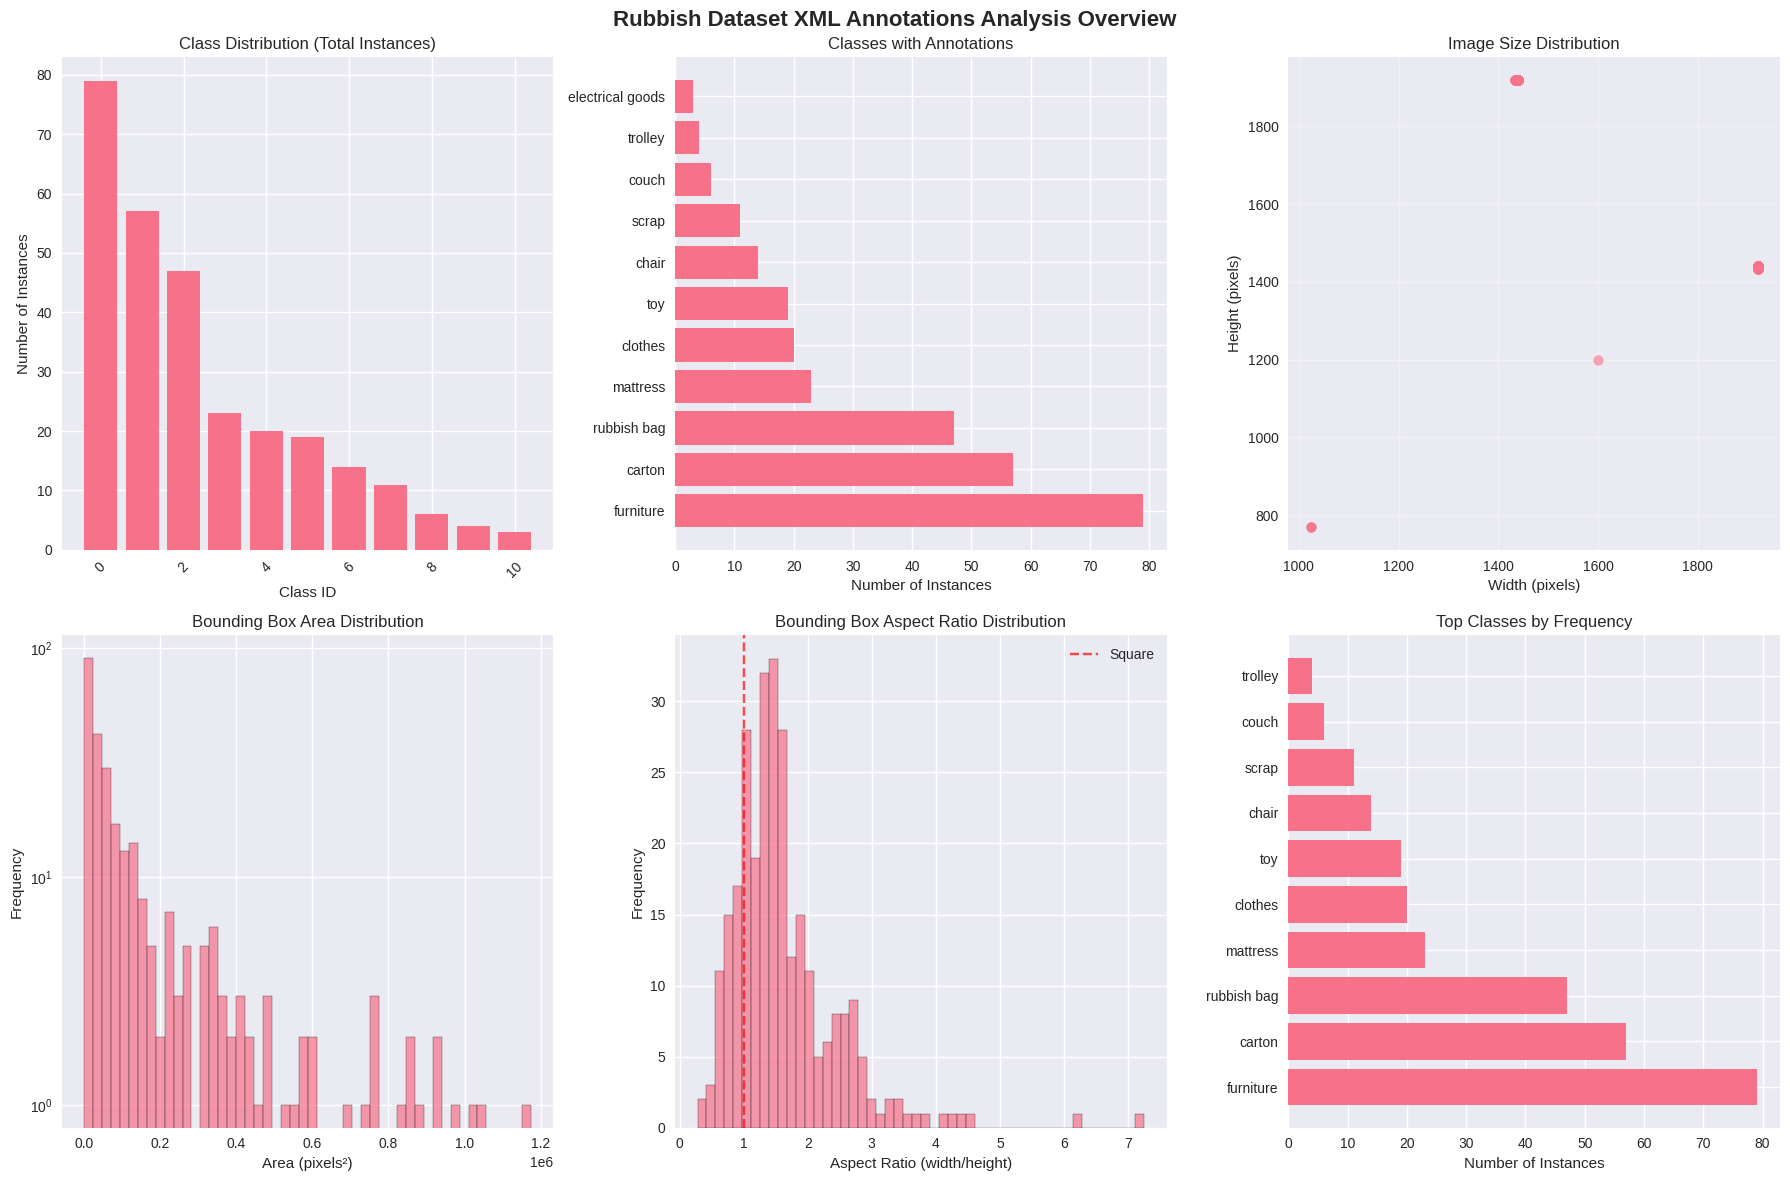

In [18]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Rubbish Dataset XML Annotations Analysis Overview', fontsize=16, fontweight='bold')

# 1. Class distribution
class_names = [classes[i] for i in range(len(classes))]
class_counts_list = [all_class_counts[i] for i in range(len(classes))]

axes[0, 0].bar(range(len(classes)), class_counts_list)
axes[0, 0].set_title('Class Distribution (Total Instances)')
axes[0, 0].set_xlabel('Class ID')
axes[0, 0].set_ylabel('Number of Instances')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Class distribution by name (more readable)
# Only show classes that have instances
non_zero_classes = [(name, count) for name, count in zip(class_names, class_counts_list) if count > 0]
if non_zero_classes:
    names, counts = zip(*non_zero_classes)
    axes[0, 1].barh(range(len(names)), counts)
    axes[0, 1].set_yticks(range(len(names)))
    axes[0, 1].set_yticklabels(names)
    axes[0, 1].set_title('Classes with Annotations')
    axes[0, 1].set_xlabel('Number of Instances')
else:
    axes[0, 1].text(0.5, 0.5, 'No annotations found', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Classes with Annotations')

# 3. Image size distribution
if all_image_stats:
    widths = [stat['width'] for stat in all_image_stats]
    heights = [stat['height'] for stat in all_image_stats]
    
    axes[0, 2].scatter(widths, heights, alpha=0.6)
    axes[0, 2].set_title('Image Size Distribution')
    axes[0, 2].set_xlabel('Width (pixels)')
    axes[0, 2].set_ylabel('Height (pixels)')
    axes[0, 2].grid(True, alpha=0.3)
else:
    axes[0, 2].text(0.5, 0.5, 'No image data', ha='center', va='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('Image Size Distribution')

# 4. Bounding box area distribution
if all_bbox_stats:
    bbox_areas = [stat['area'] for stat in all_bbox_stats]
    axes[1, 0].hist(bbox_areas, bins=50, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Bounding Box Area Distribution')
    axes[1, 0].set_xlabel('Area (pixels²)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_yscale('log')
else:
    axes[1, 0].text(0.5, 0.5, 'No bounding box data', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Bounding Box Area Distribution')

# 5. Bounding box aspect ratio distribution
if all_bbox_stats:
    bbox_aspect_ratios = [stat['aspect_ratio'] for stat in all_bbox_stats if stat['aspect_ratio'] > 0]
    axes[1, 1].hist(bbox_aspect_ratios, bins=50, alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Bounding Box Aspect Ratio Distribution')
    axes[1, 1].set_xlabel('Aspect Ratio (width/height)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(x=1, color='red', linestyle='--', alpha=0.7, label='Square')
    axes[1, 1].legend()
else:
    axes[1, 1].text(0.5, 0.5, 'No bounding box data', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Bounding Box Aspect Ratio Distribution')

# 6. Top classes by frequency
if non_zero_classes:
    top_classes = sorted(non_zero_classes, key=lambda x: x[1], reverse=True)[:10]
    top_names, top_counts = zip(*top_classes)
    
    axes[1, 2].barh(range(len(top_names)), top_counts)
    axes[1, 2].set_yticks(range(len(top_names)))
    axes[1, 2].set_yticklabels(top_names)
    axes[1, 2].set_title('Top Classes by Frequency')
    axes[1, 2].set_xlabel('Number of Instances')
else:
    axes[1, 2].text(0.5, 0.5, 'No annotations found', ha='center', va='center', transform=axes[1, 2].transAxes)
    axes[1, 2].set_title('Top Classes by Frequency')

plt.tight_layout()
plt.show()


In [19]:
# Detailed statistics
print("\n" + "="*50)
print("DETAILED DATASET STATISTICS")
print("="*50)

print(f"\nTotal Images: {len(all_image_stats)}")
print(f"Total Annotations: {len(all_bbox_stats)}")
print(f"Average Annotations per Image: {len(all_bbox_stats)/len(all_image_stats):.2f}")

if all_image_stats:
    widths = [stat['width'] for stat in all_image_stats]
    heights = [stat['height'] for stat in all_image_stats]
    aspect_ratios = [stat['aspect_ratio'] for stat in all_image_stats]
    
    print(f"\nImage Dimensions:")
    print(f"  Width: {min(widths)} - {max(widths)} (avg: {np.mean(widths):.1f})")
    print(f"  Height: {min(heights)} - {max(heights)} (avg: {np.mean(heights):.1f})")
    print(f"  Aspect Ratio: {min(aspect_ratios):.2f} - {max(aspect_ratios):.2f} (avg: {np.mean(aspect_ratios):.2f})")

if all_bbox_stats:
    bbox_areas = [stat['area'] for stat in all_bbox_stats]
    bbox_aspect_ratios = [stat['aspect_ratio'] for stat in all_bbox_stats if stat['aspect_ratio'] > 0]
    
    print(f"\nBounding Box Statistics:")
    print(f"  Area: {min(bbox_areas):.0f} - {max(bbox_areas):.0f} pixels² (avg: {np.mean(bbox_areas):.0f})")
    print(f"  Aspect Ratio: {min(bbox_aspect_ratios):.2f} - {max(bbox_aspect_ratios):.2f} (avg: {np.mean(bbox_aspect_ratios):.2f})")

print(f"\nClass Distribution:")
for i, (class_name, count) in enumerate(zip(class_names, class_counts_list)):
    percentage = (count / sum(class_counts_list)) * 100 if sum(class_counts_list) > 0 else 0
    print(f"  {i:2d}. {class_name:<20}: {count:3d} instances ({percentage:5.1f}%)")



DETAILED DATASET STATISTICS

Total Images: 126
Total Annotations: 283
Average Annotations per Image: 2.25

Image Dimensions:
  Width: 1024 - 1920 (avg: 1568.2)
  Height: 768 - 1920 (avg: 1749.3)
  Aspect Ratio: 0.75 - 1.34 (avg: 0.94)

Bounding Box Statistics:
  Area: 682 - 1174998 pixels² (avg: 145831)
  Aspect Ratio: 0.28 - 7.26 (avg: 1.63)

Class Distribution:
   0. furniture           :  79 instances ( 27.9%)
   1. carton              :  57 instances ( 20.1%)
   2. rubbish bag         :  47 instances ( 16.6%)
   3. mattress            :  23 instances (  8.1%)
   4. clothes             :  20 instances (  7.1%)
   5. toy                 :  19 instances (  6.7%)
   6. chair               :  14 instances (  4.9%)
   7. scrap               :  11 instances (  3.9%)
   8. couch               :   6 instances (  2.1%)
   9. trolley             :   4 instances (  1.4%)
  10. electrical goods    :   3 instances (  1.1%)


In [22]:
# Basic data quality check
print("\n" + "="*50)
print("BASIC DATA QUALITY CHECK")
print("="*50)

# Check for potential issues
issues = []

# 1. Class imbalance
max_count = max(class_counts_list) if class_counts_list else 0
min_count = min(class_counts_list) if class_counts_list else 0
if max_count > 0 and min_count > 0:
    imbalance_ratio = max_count / min_count
    if imbalance_ratio > 10:
        issues.append(f"Severe class imbalance (ratio: {imbalance_ratio:.1f}:1)")
    elif imbalance_ratio > 5:
        issues.append(f"Moderate class imbalance (ratio: {imbalance_ratio:.1f}:1)")

# 2. Small bounding boxes
if all_bbox_stats:
    small_boxes = [stat for stat in all_bbox_stats if stat['area'] < 100]
    if len(small_boxes) > len(all_bbox_stats) * 0.1:
        issues.append(f"Many small boxes ({len(small_boxes)} < 100 pixels²)")

# Report issues
if issues:
    print("\nISSUES:")
    for i, issue in enumerate(issues, 1):
        print(f"  {i}. {issue}")
else:
    print("\n✅ No major issues detected!")

print(f"\nSUMMARY:")
print(f"  Total images: {len(all_image_stats)}")
print(f"  Total annotations: {len(all_bbox_stats)}")
print(f"  Classes with data: {len([c for c in class_counts_list if c > 0])}")
print(f"  Avg annotations per image: {len(all_bbox_stats)/len(all_image_stats):.1f}" if all_image_stats else "  Avg annotations per image: 0")



BASIC DATA QUALITY CHECK

ISSUES:
  1. Severe class imbalance (ratio: 26.3:1)

SUMMARY:
  Total images: 126
  Total annotations: 283
  Classes with data: 11
  Avg annotations per image: 2.2


In [21]:
# Show class distribution details
print("\n" + "="*50)
print("CLASS DISTRIBUTION DETAILS")
print("="*50)

print(f"\nClasses with annotations:")
for i, (class_name, count) in enumerate(zip(class_names, class_counts_list)):
    if count > 0:
        percentage = (count / sum(class_counts_list)) * 100 if sum(class_counts_list) > 0 else 0
        print(f"  {i:2d}. {class_name:<20}: {count:3d} instances ({percentage:5.1f}%)")

print(f"\nXML annotations contain:")
print(f"  - {len(all_image_stats)} images")
print(f"  - {len(all_bbox_stats)} object annotations")
print(f"  - {len([c for c in class_counts_list if c > 0])} classes with data")



CLASS DISTRIBUTION DETAILS

Classes with annotations:
   0. furniture           :  79 instances ( 27.9%)
   1. carton              :  57 instances ( 20.1%)
   2. rubbish bag         :  47 instances ( 16.6%)
   3. mattress            :  23 instances (  8.1%)
   4. clothes             :  20 instances (  7.1%)
   5. toy                 :  19 instances (  6.7%)
   6. chair               :  14 instances (  4.9%)
   7. scrap               :  11 instances (  3.9%)
   8. couch               :   6 instances (  2.1%)
   9. trolley             :   4 instances (  1.4%)
  10. electrical goods    :   3 instances (  1.1%)

XML annotations contain:
  - 126 images
  - 283 object annotations
  - 11 classes with data
